We now train the VQVAE on the Yann LeCun's MNIST dataset.

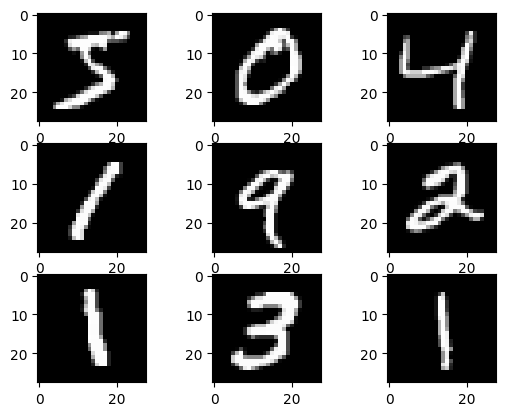

In [8]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tensorflow
import jax
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train = np.array(x_train, dtype=float)
x_test = np.array(x_test, dtype=float)

x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)


for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i][0], cmap="gray")

plt.show()

![CleanShot 2024-10-28 at 09.21.06@2x.png](<attachment:CleanShot 2024-10-28 at 09.21.06@2x.png>)

Losses to take into account
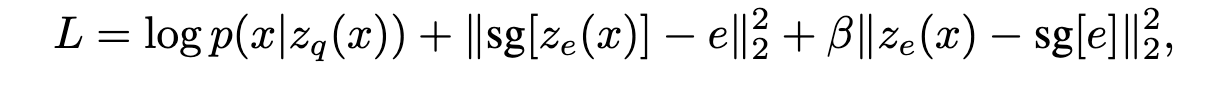

In [22]:
import optax
from VQVAE import Encoder, Decoder, Quantizer
import jax
import equinox as eqx
from optax._src.base import GradientTransformation
from jaxtyping import PyTree

class VQVAE(eqx.Module):
    quantizer: Quantizer
    encoder: Encoder
    decoder: Decoder

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.encoder = Encoder(dim=4, key=key1)
        self.decoder = Decoder(dim=4, key=key2)
        self.quantizer = Quantizer(100, 7*7, key3)

    def __call__(self, x, state):
        z_e, state = self.encoder(x, state)
        z_q = self.quantizer(z_e)
        y, state = self.decoder(z_q, state)
        return y, z_q, z_e, state

class Trainer:
    vqvae: VQVAE
    beta: float
    opt_state: optax.ScaleByAdamState
    optimizer: GradientTransformation
    state: eqx.nn.State
    
    def __init__(self, beta: float, optimizer, checkpoint=None, key=None):

        self.vqvae, self.state = eqx.nn.make_with_state(VQVAE)(key=key)
        
        if checkpoint is not None:
            self.vqvae = eqx.tree_deserialise_leaves(checkpoint, self.vqvae)
        self.optimizer = optimizer
        
        
        # Initialize optimizer state with only trainable parameters
        self.opt_state = self.optimizer.init(eqx.filter(self.vqvae, eqx.is_array))
        self.beta = beta
    
    def forward(self, model, x, state):
        return jax.vmap(
            model,
            axis_name="batch2",
            out_axes=(0, 0, 0, None),
            in_axes=(0, None)
        )(x, state)
    
    @eqx.filter_value_and_grad(has_aux=True)
    def loss(self, x, state):
        # Recreate full model for loss computation
        y, z_q, z_e, state = self.forward(self.vqvae, x, state)

        MSE = jax.numpy.mean((x - y) ** 2)
        encoding_loss = jax.numpy.mean((jax.lax.stop_gradient(z_e) - z_q) ** 2)
        commit_loss = jax.numpy.mean((z_e - jax.lax.stop_gradient(z_q)) ** 2)

        total_loss = MSE + encoding_loss + self.beta * commit_loss
        return total_loss, (MSE, encoding_loss, commit_loss, state)

    def make_step(self, x):
    # Calculate losses and gradients
        (total_loss, (MSE, encoding_loss, commit_loss, self.state)), grads = self.loss(x, self.state)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state, self.vqvae)
        self.vqvae = eqx.apply_updates(self.vqvae, updates)
        
        return MSE, encoding_loss, commit_loss
        
    def serialize(self, checkpoint):
        eqx.tree_serialise_leaves(checkpoint, self.vqvae)


In [25]:
import os
import argparse
import jax
import wandb
import optax
from tqdm.notebook import tqdm  # Use tqdm for Jupyter notebooks

def parse_args():
    parser = argparse.ArgumentParser(description="Train a VQ-VAE on the MNIST dataset.")
    parser.add_argument(
        "-f", "--file", type=str, required=True, help="path to the json config file."
    )
    parser.add_argument(
        "-chkp", "--checkpoint", type=str, help="path to train state pkl file."
    )
    return parser.parse_args()

def main(beta=0.9, learning_rate=1e-5, checkpoint=None, epochs=100, batch_size=2096, seed=69):

    run = wandb.init(
        # Set the project where this run will be logged
        project="VQVAE JAX",
        name="Training using MNIST",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size,
            "PRNG_SEED": seed,
        },
    )

    optim = optax.adam(learning_rate)

    key = jax.random.PRNGKey(seed)
    trainer = Trainer(beta=beta, optimizer=optim, checkpoint=checkpoint, key=key)
    
    dataset_size = x_train.shape[0]
    print(f"Dataset size: {dataset_size}")
    
    os.makedirs("checkpoint", exist_ok=True)

    for epoch in range(epochs):
        key = jax.random.PRNGKey(epoch)  # Different key for each epoch
        permutations_indices = jax.random.permutation(key, dataset_size)
        
        with tqdm(total=dataset_size, desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for i in range(0, dataset_size, batch_size):
                end_idx = min(i + batch_size, dataset_size)
                indices = permutations_indices[i:end_idx]
                x = x_train[indices]
                
                # Pad batch if needed
                if x.shape[0] < batch_size:
                    pad_size = batch_size - x.shape[0]
                    x = jax.numpy.pad(x, ((0, pad_size), (0, 0), (0, 0), (0, 0)), mode='edge')
                
                MSE, encoding_loss, commit_loss = trainer.make_step(x)  # Assuming make_step returns the loss
                wandb.log({"MSE": MSE, "Embedding loss": encoding_loss, "Commit loss": commit_loss})
                pbar.set_postfix({"MSE": MSE, "Embedding loss": encoding_loss, "Commit loss": commit_loss})  # Display the loss in the progress bar
                pbar.update(x.shape[0])  # Update the progress bar

    if epoch % 20 == 0:
        trainer.serialize(os.path.join("checkpoint", f"generator_epoch_{epoch}.eqx"))

main()

Commit loss,▃▅▇▅▃▃▅▆▅▄▅▅▅▆▄▅▄█▅▄▁▄▅▅▆▄▅▅▅▅▃▂▆▄▆▆▅▄▇▅
Embedding loss,▃▃▆▄▅▆▄▃▅▅▅▅▄▅█▅▄▃▃▃▄▄▆▆▅▆▅▁▄▄▄▄▂▃▄▆▅█▆▅
MSE,▆▄█▂▇▅▅▄▅▆▃▅▄▄▇▁▃▆▃▇▂▇▃▃▁▆▅▇▄▆▃▃▄▅▅▅▄▄▃▅
Commit loss,307.0412
Embedding loss,307.0412
MSE,6869.80713


Dataset size: 60000


Epoch 1/1:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
import jax
import equinox as eqx

def print_param_types(module, path=""):
    flat_params, _ = jax.tree_util.tree_flatten(module)
    for i, param in enumerate(flat_params):
        param_type = type(param)
        if isinstance(param, jax.Array):
            print(f"Parameter {i} ({path}): dtype={param.dtype}, shape={param.shape}")
        else:
            print(f"Parameter {i} ({path}): type={param_type}")

# In your Trainer class's __init__ method, add this line after initializing self.vqvae
print("Checking parameter types in vqvae:")
key = jax.random.PRNGKey(59)
print_param_types(VQVAE(key))

I'm having issues with the training parameters being misinterpreted by JAX when it traverses the pytree.

In [ ]:
import optax
from VQVAE import Encoder, Decoder, Quantizer, ResBlock
import jax
import equinox as eqx
from optax._src.base import GradientTransformation
from jaxtyping import PyTree

class VQVAE(eqx.Module):
    quantizer: Quantizer
    # encoder: Encoder
    # decoder: Decoder

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # self.encoder = Encoder(dim=4, key=key1)
        # self.decoder = Decoder(dim=4, key=key2)
        self.quantizer = Quantizer(10, 7*7, key3)

    def __call__(self, x, state):
        # z_e, state = self.encoder(x, state)
        x = self.quantizer(x)
        return self.decoder(x, state)

class Trainer:
    vqvae: VQVAE
    beta: float
    opt_state: optax.ScaleByAdamState
    optimizer: GradientTransformation
    state: eqx.nn.State
    
    def __init__(self, beta: float, optimizer, checkpoint=None):
        key = jax.random.PRNGKey(69)
        self.vqvae, self.state = eqx.nn.make_with_state(VQVAE)(key=key)
        if checkpoint is not None:
            self.vqvae = eqx.tree_deserialise_leaves(checkpoint, self.vqvae)
        self.optimizer = optimizer
        
        
        # Initialize optimizer state with only trainable parameters
        self.opt_state = self.optimizer.init(self.vqvae)
        self.beta = beta
    
    # @jax.jit
    def forward(self, model, x, state):
        return jax.vmap(
            model,
            axis_name="batch",
            in_axes=(0, None),
            out_axes=(0, 0, 0, None)
        )(x, state)
    
    # @jax.jit
    @eqx.filter_value_and_grad(has_aux=True)
    def loss(self, x, state):
        # Recreate full model for loss computation
        z_e, state = self.forward(self.vqvae, x, state)

        MSE = jax.numpy.mean((z_e) ** 2)
        total_loss = MSE
        return total_loss, state
    
    def make_step(self, x):
        (total_loss, self.state), grads = self.loss(x, self.state)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state, self.vqvae)
        print("Trainable params and updates")
        print(self.trainable_params)
        print(updates)
        print(self.opt_state)
        # print(self.vqvae)
        self.trainable_params = optax.apply_updates(self.vqvae, updates)
        
        print(f"Loss: {total_loss}")
        
    def serialize(self, checkpoint):
        eqx.tree_serialise_leaves(checkpoint, self.vqvae)

def main(beta=0.9, learning_rate=1e-5, batch_size=8):
    optim = optax.adam(learning_rate)
    trainer = Trainer(beta=beta, optimizer=optim)
    data = x_train[0:batch_size]
    trainer.make_step(data)

main()